# Overview
This is kernel is almost the same as [Lightweight Roberta solution in PyTorch](https://www.kaggle.com/andretugan/lightweight-roberta-solution-in-pytorch), but instead of "roberta-base", it starts from [Maunish's pre-trained model](https://www.kaggle.com/maunish/clrp-roberta-base).

Acknowledgments: some ideas were taken from kernels by [Torch](https://www.kaggle.com/rhtsingh) and [Maunish](https://www.kaggle.com/maunish).

In [15]:
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import gc
gc.enable()

In [2]:
NUM_FOLDS = 5
NUM_EPOCHS = 6 # default = 3, LP-FT = 6
BATCH_SIZE = 16
MAX_LEN = 248
EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
ROBERTA_PATH = "../input/clrp-roberta-base/clrp_roberta_base"
TOKENIZER_PATH = "../input/clrp-roberta-base/clrp_roberta_base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [4]:
train_df = pd.read_csv("/kaggle/input/commonlitreadabilityprize/train.csv")

# Remove incomplete entries if any.
train_df.drop(train_df[(train_df.target == 0) & (train_df.standard_error == 0)].index,
              inplace=True)
train_df.reset_index(drop=True, inplace=True)

test_df = pd.read_csv("/kaggle/input/commonlitreadabilityprize/test.csv")
submission_df = pd.read_csv("/kaggle/input/commonlitreadabilityprize/sample_submission.csv")

In [5]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# Dataset

In [6]:
class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only
        self.text = df.excerpt.tolist()
        #self.text = [text.replace("\n", " ") for text in self.text]
        
        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32)        
    
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True,
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return (input_ids, attention_mask)            
        else:
            target = self.target[index]
            return (input_ids, attention_mask, target)

# Model
The model is inspired by the one from [Maunish](https://www.kaggle.com/maunish/clrp-roberta-svm).

In [7]:
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH)
        config.update({"output_hidden_states":True, 
                       "hidden_dropout_prob": 0.0,
                       "layer_norm_eps": 1e-7})                       
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config)  
            
        self.attention = nn.Sequential(            
            nn.Linear(768, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(                        
            nn.Linear(768, 1)                        
        )
        

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids,
                                      attention_mask=attention_mask)        

        # There are a total of 13 layers of hidden states.
        # 1 for the embedding layer, and 12 for the 12 Roberta layers.
        # We take the hidden states from the last Roberta layer.
        last_layer_hidden_states = roberta_output.hidden_states[-1]

        # The number of cells is MAX_LEN.
        # The size of the hidden state of each cell is 768 (for roberta-base).
        # In order to condense hidden states of all cells to a context vector,
        # we compute a weighted average of the hidden states of all cells.
        # We compute the weight of each cell, using the attention neural network.
        weights = self.attention(last_layer_hidden_states)
                
        # weights.shape is BATCH_SIZE x MAX_LEN x 1
        # last_layer_hidden_states.shape is BATCH_SIZE x MAX_LEN x 768        
        # Now we compute context_vector as the weighted average.
        # context_vector.shape is BATCH_SIZE x 768
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        
        # Now we reduce the context vector to the prediction score.
        return self.regressor(context_vector)

In [8]:
def eval_mse(model, data_loader):
    """Evaluates the mean squared error of the |model| on |data_loader|"""
    model.eval()            
    mse_sum = 0

    with torch.no_grad():
        for batch_num, (input_ids, attention_mask, target) in enumerate(data_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)                        
            target = target.to(DEVICE)           
            
            pred = model(input_ids, attention_mask)                       

            mse_sum += nn.MSELoss(reduction="sum")(pred.flatten(), target).item()
                

    return mse_sum / len(data_loader.dataset)

In [9]:
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()

    result = np.zeros(len(data_loader.dataset))    
    index = 0
    
    with torch.no_grad():
        for batch_num, (input_ids, attention_mask) in enumerate(data_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
                        
            pred = model(input_ids, attention_mask)                        

            result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
            index += pred.shape[0]

    return result

In [10]:
def train(model, model_path, train_loader, val_loader,
          optimizer, scheduler=None, num_epochs=NUM_EPOCHS,
          fold=0, logger=None):    
    best_val_rmse = None
    best_epoch = 0
    step = 0
    last_eval_step = 0
    eval_period = EVAL_SCHEDULE[0][1]
    step_per_epoch = len(train_loader)

    start = time.time()

    # Freeze
    for param in model.roberta.parameters():
        param.requires_grad = False
        
    for epoch in range(num_epochs):
        # Unfreeze
        if epoch == 3:
            for param in model.roberta.parameters():
                param.requires_grad = True
        
        val_rmse = None

        for batch_num, (input_ids, attention_mask, target) in enumerate(train_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)            
            target = target.to(DEVICE)                        

            optimizer.zero_grad()
            
            model.train()

            pred = model(input_ids, attention_mask)
                                                        
            mse = nn.MSELoss(reduction="mean")(pred.flatten(), target)
                        
            mse.backward()

            optimizer.step()
            if scheduler:
                scheduler.step()
                
            logger["train"][fold][step] = mse
            
            if step >= last_eval_step + eval_period:
                # Evaluate the model on val_loader.
                elapsed_seconds = time.time() - start
                num_steps = step - last_eval_step
                print(f"\n{num_steps} steps took {elapsed_seconds:0.3} seconds")
                last_eval_step = step
                
                val_rmse = math.sqrt(eval_mse(model, val_loader))                            

                print(f"Epoch: {epoch} batch_num: {batch_num}", 
                      f"val_rmse: {val_rmse:0.4}")

                for rmse, period in EVAL_SCHEDULE:
                    if val_rmse >= rmse:
                        eval_period = period
                        break                               
                
                if not best_val_rmse or val_rmse < best_val_rmse:                    
                    best_val_rmse = val_rmse
                    best_epoch = epoch
                    torch.save(model.state_dict(), model_path)
                    print(f"New best_val_rmse: {best_val_rmse:0.4}")
                else:       
                    print(f"Still best_val_rmse: {best_val_rmse:0.4}",
                          f"(from epoch {best_epoch})")                                    
                
                logger["valid"][fold][step] = val_rmse
                
                start = time.time()
                                            
            step += 1
                        
    
    return best_val_rmse

In [11]:
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:197]    
    attention_parameters = named_parameters[199:203]
    regressor_parameters = named_parameters[203:]
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})

    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = 2e-5

        if layer_num >= 69:        
            lr = 5e-5

        if layer_num >= 133:
            lr = 1e-4

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters)

In [13]:
gc.collect()

SEED = 1000
list_val_rmse = []
logger = {
    "train": [{} for _ in range(NUM_FOLDS)],
    "valid": [{} for _ in range(NUM_FOLDS)]
}

kfold = KFold(n_splits=NUM_FOLDS, random_state=SEED, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(train_df)):    
    print(f"\nFold {fold + 1}/{NUM_FOLDS}")
    model_path = f"model_{fold + 1}.pth"
        
    set_random_seed(SEED + fold)
    
    train_dataset = LitDataset(train_df.loc[train_indices])    
    val_dataset = LitDataset(train_df.loc[val_indices])    
        
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              drop_last=True, shuffle=True, num_workers=2)    
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            drop_last=False, shuffle=False, num_workers=2)    
        
    set_random_seed(SEED + fold)    
    
    model = LitModel().to(DEVICE)
    
    optimizer = create_optimizer(model)                        
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_training_steps=NUM_EPOCHS * len(train_loader),
        num_warmup_steps=50)    
    
    list_val_rmse.append(train(model, model_path, train_loader,
                               val_loader, optimizer, scheduler=scheduler,
                               fold=fold, logger=logger))

    del model
    gc.collect()
    
    print("\nPerformance estimates:")
    print(list_val_rmse)
    print("Mean:", np.array(list_val_rmse).mean())
    


Fold 1/5


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 3.18 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.355
New best_val_rmse: 1.355

16 steps took 2.06 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.9755
New best_val_rmse: 0.9755

16 steps took 2.07 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.9206
New best_val_rmse: 0.9206

16 steps took 2.09 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.8673
New best_val_rmse: 0.8673

16 steps took 2.06 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.8171
New best_val_rmse: 0.8171

16 steps took 2.06 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.7786
New best_val_rmse: 0.7786

16 steps took 2.06 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.7526
New best_val_rmse: 0.7526

16 steps took 2.07 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.752
New best_val_rmse: 0.752

16 steps took 2.22 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.7177
New best_val_rmse: 0.7177

16 steps took 2.05 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.7251
Still best_val_rmse: 0.7177 (from epoch 1)

16 steps took 2.06 seconds
Epoch: 1 batch_num

Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 2.35 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.358
New best_val_rmse: 1.358

16 steps took 2.05 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.9878
New best_val_rmse: 0.9878

16 steps took 2.07 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.9165
New best_val_rmse: 0.9165

16 steps took 2.05 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.8272
New best_val_rmse: 0.8272

16 steps took 2.06 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.7552
New best_val_rmse: 0.7552

16 steps took 2.07 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.727
New best_val_rmse: 0.727

16 steps took 2.06 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.7168
New best_val_rmse: 0.7168

16 steps took 2.06 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.6956
New best_val_rmse: 0.6956

16 steps took 2.13 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.6931
New best_val_rmse: 0.6931

16 steps took 2.06 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.6837
New best_val_rmse: 0.6837

16 steps took 2.07 seconds
Epoch: 1 batch_num: 35 val_rmse: 0.

Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 2.34 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.401
New best_val_rmse: 1.401

16 steps took 2.06 seconds
Epoch: 0 batch_num: 32 val_rmse: 1.05
New best_val_rmse: 1.05

16 steps took 2.06 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.9851
New best_val_rmse: 0.9851

16 steps took 2.06 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.9004
New best_val_rmse: 0.9004

16 steps took 2.08 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.8358
New best_val_rmse: 0.8358

16 steps took 2.07 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.7663
New best_val_rmse: 0.7663

16 steps took 2.06 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.7674
Still best_val_rmse: 0.7663 (from epoch 0)

16 steps took 2.06 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.7542
New best_val_rmse: 0.7542

16 steps took 2.14 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.7228
New best_val_rmse: 0.7228

16 steps took 2.08 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.7156
New best_val_rmse: 0.7156

16 steps took 2.06 seconds
Epoch: 1 batch_num: 

Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 2.34 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.306
New best_val_rmse: 1.306

16 steps took 2.06 seconds
Epoch: 0 batch_num: 32 val_rmse: 1.034
New best_val_rmse: 1.034

16 steps took 2.08 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.9517
New best_val_rmse: 0.9517

16 steps took 2.06 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.8693
New best_val_rmse: 0.8693

16 steps took 2.07 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.8101
New best_val_rmse: 0.8101

16 steps took 2.06 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.7627
New best_val_rmse: 0.7627

16 steps took 2.07 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.7595
New best_val_rmse: 0.7595

16 steps took 2.06 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.7328
New best_val_rmse: 0.7328

16 steps took 2.17 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.7232
New best_val_rmse: 0.7232

16 steps took 2.06 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.711
New best_val_rmse: 0.711

16 steps took 2.06 seconds
Epoch: 1 batch_num: 35 val_rmse: 0.71

Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 2.35 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.282
New best_val_rmse: 1.282

16 steps took 2.06 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.9852
New best_val_rmse: 0.9852

16 steps took 2.08 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.9029
New best_val_rmse: 0.9029

16 steps took 2.06 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.8116
New best_val_rmse: 0.8116

16 steps took 2.07 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.7595
New best_val_rmse: 0.7595

16 steps took 2.07 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.7515
New best_val_rmse: 0.7515

16 steps took 2.06 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.736
New best_val_rmse: 0.736

16 steps took 2.06 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.7172
New best_val_rmse: 0.7172

16 steps took 2.2 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.7284
Still best_val_rmse: 0.7172 (from epoch 0)

16 steps took 2.06 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.7
New best_val_rmse: 0.7

16 steps took 2.06 seconds
Epoch: 1 batch_num: 35 va

Text(0.5, 1.0, 'Valid')

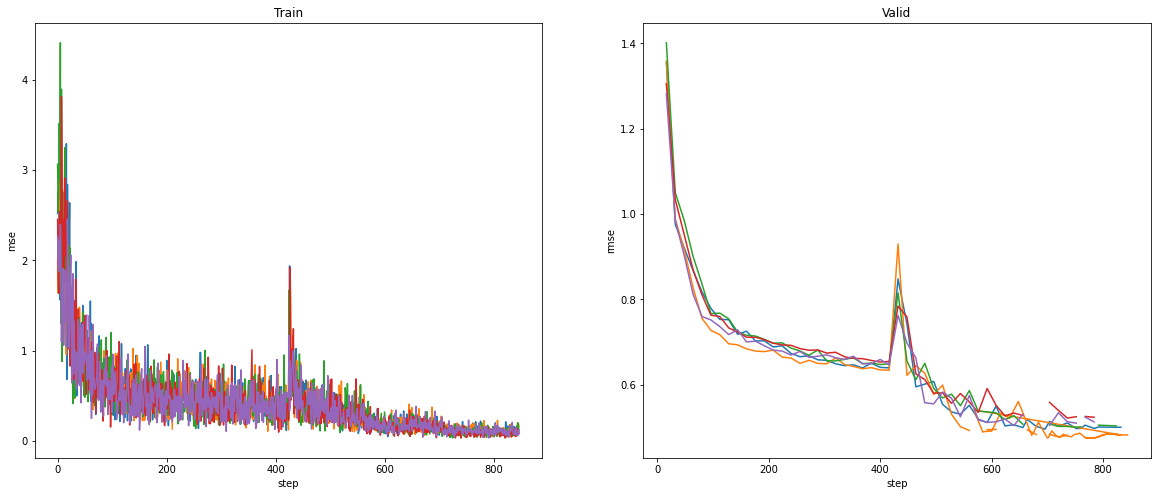

In [26]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(pd.DataFrame(logger["train"]).T)
plt.xlabel("step")
plt.ylabel("mse")
plt.title("Train")

plt.subplot(1, 2, 2)
plt.plot(pd.DataFrame(logger["valid"]).T)
plt.xlabel("step")
plt.ylabel("rmse")
plt.title("Valid")

# Inference

In [22]:
test_dataset = LitDataset(test_df, inference_only=True)

In [23]:
all_predictions = np.zeros((len(list_val_rmse), len(test_df)))

test_dataset = LitDataset(test_df, inference_only=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         drop_last=False, shuffle=False, num_workers=2)

for index in range(len(list_val_rmse)):            
    model_path = f"model_{index + 1}.pth"
    print(f"\nUsing {model_path}")
                        
    model = LitModel()
    model.load_state_dict(torch.load(model_path))    
    model.to(DEVICE)
    
    all_predictions[index] = predict(model, test_loader)
    
    del model
    gc.collect()


Using model_1.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using model_2.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using model_3.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using model_4.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using model_5.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
predictions = all_predictions.mean(axis=0)
submission_df.target = predictions
print(submission_df)
submission_df.to_csv("submission.csv", index=False)

          id    target
0  c0f722661 -0.528908
1  f0953f0a5 -0.570558
2  0df072751 -0.491086
3  04caf4e0c -2.394025
4  0e63f8bea -1.750019
5  12537fe78 -1.266577
6  965e592c0  0.189861
